<a href="https://colab.research.google.com/github/TharukaSiriwardana/TDM_ML_Assignment_2/blob/main/TDM_PIFuHD_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PIFuHD Demo: https://shunsukesaito.github.io/PIFuHD/

![](https://shunsukesaito.github.io/PIFuHD/resources/images/pifuhd.gif)

Made by [![Follow](https://img.shields.io/twitter/follow/psyth91?style=social)](https://twitter.com/psyth91)

To see how the model works, visit the project repository.

[![GitHub stars](https://img.shields.io/github/stars/facebookresearch/pifuhd?style=social)](https://github.com/facebookresearch/pifuhd)

## Note
Make sure that your runtime type is 'Python 3 with GPU acceleration'. To do so, go to Edit > Notebook settings > Hardware Accelerator > Select "GPU".

## More Info
- Paper: https://arxiv.org/pdf/2004.00452.pdf
- Repo: https://github.com/facebookresearch/pifuhd
- Project Page: https://shunsukesaito.github.io/PIFuHD/
- 1-minute/5-minute Presentation (see below)

In [ ]:
import IPython
IPython.display.HTML('<h2>1-Minute Presentation</h2><iframe width="720" height="405" src="https://www.youtube.com/embed/-1XYTmm8HhE" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe><br><h2>5-Minute Presentation</h2><iframe width="720" height="405" src="https://www.youtube.com/embed/uEDqCxvF5yc" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Requirements
- Python 3
- PyTorch tested on 1.4.0
- json
- PIL
- skimage
- tqdm
- numpy
- cv2

## Help! I'm new to Google Colab

You can check out the following youtube video on how to upload your own picture and run PIFuHD. **Note that with new update, you can upload your own picture more easily with GUI down below.**


In [ ]:
import IPython
IPython.display.HTML('<iframe width="720" height="405" src="https://www.youtube.com/embed/LWDGR5v3-3o" frameborder="0" allow="accelerometer; autoplay; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe>')

## Clone PIFuHD repository

In [ ]:
!git clone https://github.com/facebookresearch/pifuhd

Cloning into 'pifuhd'...
remote: Enumerating objects: 213, done.
remote: Total 213 (delta 0), reused 0 (delta 0), pack-reused 213
Receiving objects: 100% (213/213), 402.72 KiB | 17.51 MiB/s, done.
Resolving deltas: 100% (104/104), done.


## Configure input data

In [ ]:
cd /content/pifuhd/sample_images

/content/pifuhd/sample_images


**If you want to upload your own picture, run the next cell**. Otherwise, go to the next next cell. Currently PNG, JPEG files are supported.

In [ ]:
from google.colab import files

filename = list(files.upload().keys())[0]

Saving Man_Portrait.jpg to Man_Portrait.jpg


In [ ]:
import os

try:
  image_path = '/content/pifuhd/sample_images/Man_Portrait.png'
except:
  image_path = '/content/pifuhd/sample_images/test.png' # example image
image_dir = os.path.dirname(image_path)
file_name = os.path.splitext(os.path.basename(image_path))[0]

# output pathes
obj_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.obj' % file_name
out_img_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.png' % file_name
video_path = '/content/pifuhd/results/pifuhd_final/recon/result_%s_256.mp4' % file_name
video_display_path = '/content/pifuhd/results/pifuhd_final/result_%s_256_display.mp4' % file_name

In [ ]:
cd /content

/content


## Preprocess (for cropping image)

In [ ]:
!git clone https://github.com/Daniil-Osokin/lightweight-human-pose-estimation.pytorch.git

fatal: destination path 'lightweight-human-pose-estimation.pytorch' already exists and is not an empty directory.


In [ ]:
cd /content/lightweight-human-pose-estimation.pytorch/

/content/lightweight-human-pose-estimation.pytorch


In [ ]:
!wget https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth

--2022-04-17 10:03:06--  https://download.01.org/opencv/openvino_training_extensions/models/human_pose_estimation/checkpoint_iter_370000.pth
Resolving download.01.org (download.01.org)... 104.114.27.57, 2600:1407:3c00:1487::4b21, 2600:1407:3c00:1480::4b21
Connecting to download.01.org (download.01.org)|104.114.27.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87959810 (84M) [application/octet-stream]
Saving to: ‘checkpoint_iter_370000.pth.3’

checkpoint_iter_370 100%[===================>]  83.88M  89.6MB/s    in 0.9s    

2022-04-17 10:03:07 (89.6 MB/s) - ‘checkpoint_iter_370000.pth.3’ saved [87959810/87959810]



In [ ]:
import torch
import cv2
import numpy as np
from models.with_mobilenet import PoseEstimationWithMobileNet
from modules.keypoints import extract_keypoints, group_keypoints
from modules.load_state import load_state
from modules.pose import Pose, track_poses
import demo

def get_rect(net, images, height_size):
    net = net.eval()

    stride = 8
    upsample_ratio = 4
    num_keypoints = Pose.num_kpts
    previous_poses = []
    delay = 33
    for image in images:
        rect_path = image.replace('.%s' % (image.split('.')[-1]), '_rect.txt')
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        orig_img = img.copy()
        orig_img = img.copy()
        heatmaps, pafs, scale, pad = demo.infer_fast(net, img, height_size, stride, upsample_ratio, cpu=False)

        total_keypoints_num = 0
        all_keypoints_by_type = []
        for kpt_idx in range(num_keypoints):  # 19th for bg
            total_keypoints_num += extract_keypoints(heatmaps[:, :, kpt_idx], all_keypoints_by_type, total_keypoints_num)

        pose_entries, all_keypoints = group_keypoints(all_keypoints_by_type, pafs)
        for kpt_id in range(all_keypoints.shape[0]):
            all_keypoints[kpt_id, 0] = (all_keypoints[kpt_id, 0] * stride / upsample_ratio - pad[1]) / scale
            all_keypoints[kpt_id, 1] = (all_keypoints[kpt_id, 1] * stride / upsample_ratio - pad[0]) / scale
        current_poses = []

        rects = []
        for n in range(len(pose_entries)):
            if len(pose_entries[n]) == 0:
                continue
            pose_keypoints = np.ones((num_keypoints, 2), dtype=np.int32) * -1
            valid_keypoints = []
            for kpt_id in range(num_keypoints):
                if pose_entries[n][kpt_id] != -1.0:  # keypoint was found
                    pose_keypoints[kpt_id, 0] = int(all_keypoints[int(pose_entries[n][kpt_id]), 0])
                    pose_keypoints[kpt_id, 1] = int(all_keypoints[int(pose_entries[n][kpt_id]), 1])
                    valid_keypoints.append([pose_keypoints[kpt_id, 0], pose_keypoints[kpt_id, 1]])
            valid_keypoints = np.array(valid_keypoints)
            
            if pose_entries[n][10] != -1.0 or pose_entries[n][13] != -1.0:
              pmin = valid_keypoints.min(0)
              pmax = valid_keypoints.max(0)

              center = (0.5 * (pmax[:2] + pmin[:2])).astype(np.int)
              radius = int(0.65 * max(pmax[0]-pmin[0], pmax[1]-pmin[1]))
            elif pose_entries[n][10] == -1.0 and pose_entries[n][13] == -1.0 and pose_entries[n][8] != -1.0 and pose_entries[n][11] != -1.0:
              # if leg is missing, use pelvis to get cropping
              center = (0.5 * (pose_keypoints[8] + pose_keypoints[11])).astype(np.int)
              radius = int(1.45*np.sqrt(((center[None,:] - valid_keypoints)**2).sum(1)).max(0))
              center[1] += int(0.05*radius)
            else:
              center = np.array([img.shape[1]//2,img.shape[0]//2])
              radius = max(img.shape[1]//2,img.shape[0]//2)

            x1 = center[0] - radius
            y1 = center[1] - radius

            rects.append([x1, y1, 2*radius, 2*radius])

        np.savetxt(rect_path, np.array(rects), fmt='%d')

In [ ]:
net = PoseEstimationWithMobileNet()
checkpoint = torch.load('checkpoint_iter_370000.pth', map_location='cpu')
load_state(net, checkpoint)

get_rect(net.cuda(), [image_path], 512)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:53: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


## Download the Pretrained Model

In [ ]:
cd /content/pifuhd/

/content/pifuhd


In [ ]:
!sh ./scripts/download_trained_model.sh

+ mkdir -p checkpoints
+ cd checkpoints
+ wget https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt pifuhd.pt
--2022-04-17 10:01:33--  https://dl.fbaipublicfiles.com/pifuhd/checkpoints/pifuhd.pt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1548375177 (1.4G) [application/octet-stream]
Saving to: ‘pifuhd.pt.2’

pifuhd.pt.2         100%[===================>]   1.44G  68.2MB/s    in 21s     

2022-04-17 10:01:55 (69.1 MB/s) - ‘pifuhd.pt.2’ saved [1548375177/1548375177]

--2022-04-17 10:01:55--  http://pifuhd.pt/
Resolving pifuhd.pt (pifuhd.pt)... failed: Name or service not known.
wget: unable to resolve host address ‘pifuhd.pt’
FINISHED --2022-04-17 10:01:55--
Total wall clock time: 22s
Downloaded: 1 files, 1.4G in 21s (69.1 MB/s)


## Run PIFuHD!


In [ ]:
# Warning: all images with the corresponding rectangle files under -i will be processed. 
!python -m apps.simple_test -r 256 --use_rect -i $image_dir

# seems that 256 is the maximum resolution that can fit into Google Colab. 
# If you want to reconstruct a higher-resolution mesh, please try with your own machine. 

Resuming from  ./checkpoints/pifuhd.pt
test data size:  1
initialize network with normal
initialize network with normal
generate mesh (test) ...
  0% 0/1 [00:00<?, ?it/s]./results/pifuhd_final/recon/result_Man_Portrait_256.obj
/content/pifuhd/lib/mesh_util.py:77: FutureWarning: marching_cubes_lewiner is deprecated in favor of marching_cubes. marching_cubes_lewiner will be removed in version 0.19
  verts, faces, normals, values = measure.marching_cubes_lewiner(sdf, thresh)
100% 1/1 [00:10<00:00, 10.11s/it]


## Render the result

In [ ]:
!pip install pytorch3d

# If you get an error in the next cell, you can instead try the following command (don't forget to comment out the one above!).
# Note that this error is caused by inconsistent cuda version for the pytorch3d package and pytorch in Colab environment.
# Thus, this issue may persist unless pytorch3d in the pip package is updated with the cuda version consistent with pytorch in Colab.
# Also please be aware that the following command is much slower as it builds pytorch3d from scratch.

!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

# You can try another solution below as well. This is also slow and requires you to restart the runtime.

!pip install 'torch==1.6.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'torchvision==0.7.0+cu101' -f https://download.pytorch.org/whl/torch_stable.html
!pip install 'pytorch3d==0.2.5'

  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-wr_m8nev
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-wr_m8nev
  Running command git checkout -q 3fc3ea507bfbf7e1c2d5023a6db202698206f91d
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/base_command.py", line 180, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/req_command.py", line 199, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/commands/install.py", line 350, in run
    global_options=[],
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/wheel_builder.py", line 337, in build
    req, cache_dir, verify, build_options, global_options
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/wheel_builder.

In [ ]:
from lib.colab_util import generate_video_from_obj, set_renderer, video

renderer = set_renderer()
generate_video_from_obj(obj_path, out_img_path, video_path, renderer)

# we cannot play a mp4 video generated by cv2
!ffmpeg -i $video_path -vcodec libx264 $video_display_path -y -loglevel quiet
video(video_display_path)

  0%|          | 0/90 [00:00<?, ?it/s]

## Tips for Inputs: My results are broken!

(Kudos to those who share results on twitter with [#pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live) tag!!!!)

Due to the limited variation in the training data, your results might be broken sometimes. Here I share some useful tips to get resonable results. 

*   Use high-res image. The model is trained with 1024x1024 images. Use at least 512x512 with fine-details. Low-res images and JPEG artifacts may result in unsatisfactory results. 
*   Use an image with a single person. If the image contain multiple people, reconstruction quality is likely degraded.
*   Front facing with standing works best (or with fashion pose)
*   The entire body is covered within the image. (Note: now missing legs is partially supported)
*   Make sure the input image is well lit. Exteremy dark or bright image and strong shadow often create artifacts.
*   I recommend nearly parallel camera angle to the ground. High camera height may result in distorted legs or high heels. 
*   If the background is cluttered, use less complex background or try removing it using https://www.remove.bg/ before processing.
*   It's trained with human only. Anime characters may not work well (To my surprise, indeed many people tried it!!).
*   Search on twitter with [#pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live) tag to get a better sense of what succeeds and what fails. 


## Share your result! 
Please share your results with[ #pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live) tag on Twitter. Sharing your good/bad results helps and encourages the authors to further push towards producition-quality human digitization at home.
**As the tweet buttom below doesn't add the result video automatically, please download the result video above and manually add it to the tweet.**

In [ ]:
import IPython
IPython.display.HTML('<a href="https://twitter.com/intent/tweet?button_hashtag=pifuhd&ref_src=twsrc%5Etfw" class="twitter-hashtag-button" data-size="large" data-text="Google Colab Link: " data-url="https://bit.ly/37sfogZ" data-show-count="false">Tweet #pifuhd</a><script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>  (Don\'t forget to add your result to the tweet!)')

## Cool Applications
Special thanks to those who play with PIFuHD and came up with many creative applications!! If you made any cool applications, please tweet your demo with [#pifuhd](https://twitter.com/search?q=%23pifuhd&src=recent_search_click&f=live). I'm constantly checking results there.
If you need complete texture on the mesh, please try my previous work [PIFu](https://github.com/shunsukesaito/PIFu) as well! It supports 3D reconstruction + texturing from a single image although the geometry quality may not be as good as PIFuHD.

In [ ]:
IPython.display.HTML('<h2>Rigging (Mixamo) + Photoreal Rendering (Blender)</h2><blockquote class="twitter-tweet"><p lang="pt" dir="ltr">vcs ainda tem a PACHORRA de me dizer que eu não sei dançar<a href="https://twitter.com/hashtag/b3d?src=hash&amp;ref_src=twsrc%5Etfw">#b3d</a> <a href="https://twitter.com/hashtag/pifuhd?src=hash&amp;ref_src=twsrc%5Etfw">#pifuhd</a> <a href="https://t.co/kHCnLh6zxH">pic.twitter.com/kHCnLh6zxH</a></p>&mdash; lukas arendero (@lukazvd) <a href="https://twitter.com/lukazvd/status/1274810484798128131?ref_src=twsrc%5Etfw">June 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script><h2>FaceApp + Rigging (Mixamo)</h2><blockquote class="twitter-tweet"><p lang="ja" dir="ltr">カツラかぶってる自分に見える <a href="https://twitter.com/hashtag/pifuhd?src=hash&amp;ref_src=twsrc%5Etfw">#pifuhd</a> <a href="https://t.co/V8o7VduTiG">pic.twitter.com/V8o7VduTiG</a></p>&mdash; Shuhei Tsuchida (@shuhei2306) <a href="https://twitter.com/shuhei2306/status/1274507242910314498?ref_src=twsrc%5Etfw">June 21, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script><h2>Rigging (Mixamo) + AR (Adobe Aero)</AR><blockquote class="twitter-tweet"><p lang="ja" dir="ltr">写真→PIFuHD→Mixamo→AdobeAeroでサウンド付きARを作成。Zip化してLINEでARコンテンツを共有。<br>写真が1枚あれば簡単にARの3Dアニメーションが作れる時代…凄い。<a href="https://twitter.com/hashtag/PIFuHD?src=hash&amp;ref_src=twsrc%5Etfw">#PIFuHD</a> <a href="https://twitter.com/hashtag/AdobeAero?src=hash&amp;ref_src=twsrc%5Etfw">#AdobeAero</a> <a href="https://twitter.com/hashtag/Mixamo?src=hash&amp;ref_src=twsrc%5Etfw">#Mixamo</a> <a href="https://t.co/CbiMi4gZ0K">pic.twitter.com/CbiMi4gZ0K</a></p>&mdash; モジョン (@mojon1) <a href="https://twitter.com/mojon1/status/1273217947872317441?ref_src=twsrc%5Etfw">June 17, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script><h2>3D Printing</h2><blockquote class="twitter-tweet"><p lang="ja" dir="ltr"><a href="https://twitter.com/hashtag/pifuhd?src=hash&amp;ref_src=twsrc%5Etfw">#pifuhd</a> 楽しい〜<br>小さい自分プリントした <a href="https://t.co/4qyWuij0Hs">pic.twitter.com/4qyWuij0Hs</a></p>&mdash; isb (@vxzxzxzxv) <a href="https://twitter.com/vxzxzxzxv/status/1273136266406694913?ref_src=twsrc%5Etfw">June 17, 2020</a></blockquote> <script async src="https://platform.twitter.com/widgets.js" charset="utf-8"></script>')

NameError: ignored

**Remove Background of the uploaded image**
---
---




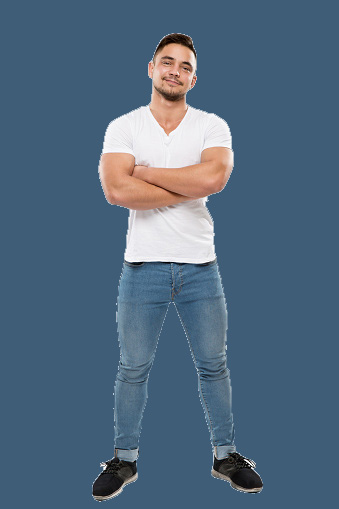

In [ ]:
import cv2
from urllib.request import urlretrieve
from google.colab.patches import cv2_imshow

# display the images in the notebook
cv2_imshow(cv2.imread('/content/pifuhd/sample_images/Man_Portrait.jpg'))

**Running Interface of the Model**

---



In [ ]:
import cv2
import torch
from PIL import Image
from torchvision import transforms
from matplotlib import pyplot as plt

def load_model():
  model = torch.hub.load('pytorch/vision:v0.6.0', 'deeplabv3_resnet101', pretrained=True)
  model.eval()
  return model

def make_transparent_foreground(pic, mask):
  # split the image into channels
  b, g, r = cv2.split(np.array(pic).astype('uint8'))
  # add an alpha channel with and fill all with transparent pixels (max 255)
  a = np.ones(mask.shape, dtype='uint8') * 255
  # merge the alpha channel back
  alpha_im = cv2.merge([b, g, r, a], 4)
  # create a transparent background
  bg = np.zeros(alpha_im.shape)
  # setup the new mask
  new_mask = np.stack([mask, mask, mask, mask], axis=2)
  # copy only the foreground color pixels from the original image where mask is set
  foreground = np.where(new_mask, alpha_im, bg).astype(np.uint8)

  return foreground

def remove_background(model, input_file):
  input_image = Image.open(input_file)
  preprocess = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])

  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)['out'][0]
  output_predictions = output.argmax(0)

  # create a binary (black and white) mask of the profile foreground
  mask = output_predictions.byte().cpu().numpy()
  background = np.zeros(mask.shape)
  bin_mask = np.where(mask, 255, background).astype(np.uint8)

  foreground = make_transparent_foreground(input_image ,bin_mask)

  return foreground, bin_mask

**Show Silhouette Image without background**

---



Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

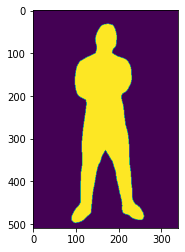

In [ ]:
import numpy as np
deeplab_model = load_model()
foreground, bin_mask = remove_background(deeplab_model, '/content/pifuhd/sample_images/Man_Portrait.jpg')
#test_image = Image.open('/content/pifuhd/sample_images/Man_Portrait.png').convert('RGB')
plt.imshow(bin_mask)

**Save & show the Background Removed Image**

---



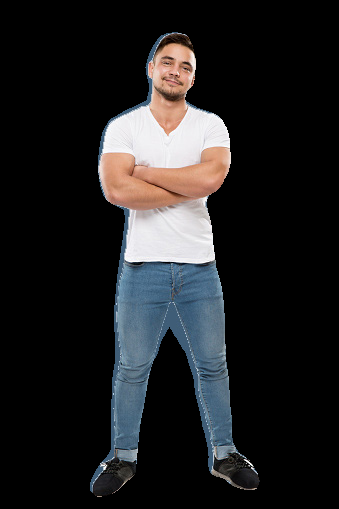

In [ ]:
Image.fromarray(foreground).save("/content/pifuhd/sample_images/Man_Portrait.png")
cv2_imshow(cv2.imread('/content/pifuhd/sample_images/Man_Portrait.png'))